# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<b>Инструкция по выполнению проекта</b>
<br>
Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Это редкие случаи, которые легко пропустить, если всегда применять только бустинг. Поэкспериментируйте и сравните характеристики моделей: скорость работы, точность результата.
<br>
- Загрузите и подготовьте данные.
<br>
- Обучите разные модели. Для каждой попробуйте различные гиперпараметры.
<br>
- Проанализируйте скорость работы и качество моделей.
<br>
<b>Примечания:</b>
<br>
- Для оценки качества моделей применяйте метрику RMSE.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.

<b>Признаки</b>
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

<b>Целевой признак</b>
- Price — цена (евро)

## Подготовка данных

### Изучение исходной информации

In [160]:
#подключим необходимые для работы библиотеки

import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
pd.options.display.float_format = '{:,.3f}'.format

import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 

In [161]:
#прочитаем исходный датафрейм

try:
    data = pd.read_csv('C:/Users/IshkulovIM/pythonworks/yandex_practikum/autos.csv', sep=',') 
    
except:
    data = pd.read_csv('/datasets/autos.csv', sep=',')

In [162]:
# изучим основную информацию о датафрейме

print('Первые 10 строк датафрейма:')
display(data.head(10))
print('Основная информация о датафрейме:')
display(data.info())
display(data.describe())
print('Размер датасета:')
display(data.shape)
print('Доля пропущенных данных в датафрейме:')
display(data.isna().mean())
print('Количество дубликатов: ')
display(data.duplicated().sum())

Первые 10 строк датафрейма:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Основная информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,"354,369.000","354,369.000","354,369.000","354,369.000","354,369.000","354,369.000","354,369.000"
mean,"4,416.657","2,004.234",110.094,"128,211.173",5.715,0.000,"50,508.689"
std,"4,514.159",90.228,189.850,"37,905.342",3.726,0.000,"25,783.096"
min,0.000,"1,000.000",0.000,"5,000.000",0.000,0.000,"1,067.000"
25%,"1,050.000","1,999.000",69.000,"125,000.000",3.000,0.000,"30,165.000"
50%,"2,700.000","2,003.000",105.000,"150,000.000",6.000,0.000,"49,413.000"
75%,"6,400.000","2,008.000",143.000,"150,000.000",9.000,0.000,"71,083.000"
max,"20,000.000","9,999.000","20,000.000","150,000.000",12.000,0.000,"99,998.000"


Размер датасета:


(354369, 16)

Доля пропущенных данных в датафрейме:


DateCrawled         0.000
Price               0.000
VehicleType         0.106
RegistrationYear    0.000
Gearbox             0.056
Power               0.000
Model               0.056
Kilometer           0.000
RegistrationMonth   0.000
FuelType            0.093
Brand               0.000
NotRepaired         0.201
DateCreated         0.000
NumberOfPictures    0.000
PostalCode          0.000
LastSeen            0.000
dtype: float64

Количество дубликатов: 


4

<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Изучив исходные данные датафрейма можно сказать, что данные по большинству признаков представлены в полном объеме. Что касается типа данных, то по ряду признаков тип данных указан некорректно. Также были обнаружены 4 полных дубликата.
  <br>   
<br> 
Помимо этого есть вопросы по корректности исходной информации. Например, минимальная мощность двигателя указана "0 л.с.", а максимальная "20 тыс л.с.", видно, что пользователи не заморачивались и писали что приходило им на ум. По столбцу "Год регистрации" также максимум далек от реальности. Также по первичному анализу можно заметить, что столбец с указанием количества картинок пуст, возможно произошла какая-то ошибка при выгрузке и данный параметр отсутствует в финальной таблице.   
</div>

In [163]:
#удалим дубликаты в исходном датафрейме

data = data.drop_duplicates()

In [164]:
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Для дальнейшей работы и обучения моделей удалим часть исходных признаков, которые не несут в себе полезной информации.   
</div>

In [165]:
#узнаем на какой период была осуществленна выгрузка базы

data['DateCrawled'].max()

'2016-04-07 14:36:58'

In [166]:
#удаляем часть признаков

data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen' ], axis=1)

In [167]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354365 non-null  int64 
 1   VehicleType       316875 non-null  object
 2   RegistrationYear  354365 non-null  int64 
 3   Gearbox           334532 non-null  object
 4   Power             354365 non-null  int64 
 5   Model             334660 non-null  object
 6   Kilometer         354365 non-null  int64 
 7   FuelType          321470 non-null  object
 8   Brand             354365 non-null  object
 9   NotRepaired       283211 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


### Анализ информации

<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Проанализируем значения в столбцах нашего датафрейма. По первичным данным было видно, что есть значения, которые сильно выбиваются, либо недостоверны. 
<br>
</div>


In [168]:
#первичный анализ данных

data.describe()

,Price,RegistrationYear,Power,Kilometer
count,"354,365.000","354,365.000","354,365.000","354,365.000"
mean,"4,416.680","2,004.234",110.094,"128,211.364"
std,"4,514.176",90.228,189.851,"37,905.084"
min,0.000,"1,000.000",0.000,"5,000.000"
25%,"1,050.000","1,999.000",69.000,"125,000.000"
50%,"2,700.000","2,003.000",105.000,"150,000.000"
75%,"6,400.000","2,008.000",143.000,"150,000.000"
max,"20,000.000","9,999.000","20,000.000","150,000.000"


<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Начнем анализ с цены автомобилей. Минимальная цена равна нулю. Думаю, что это допустимо. Возможно, что кто-то решил отдать свой автомобиль. Тем более, таких значений всего 3% от общей выборки. Максимальная цена указана в 20 тыс.евро, таких значений всего 0.075%.
</div>

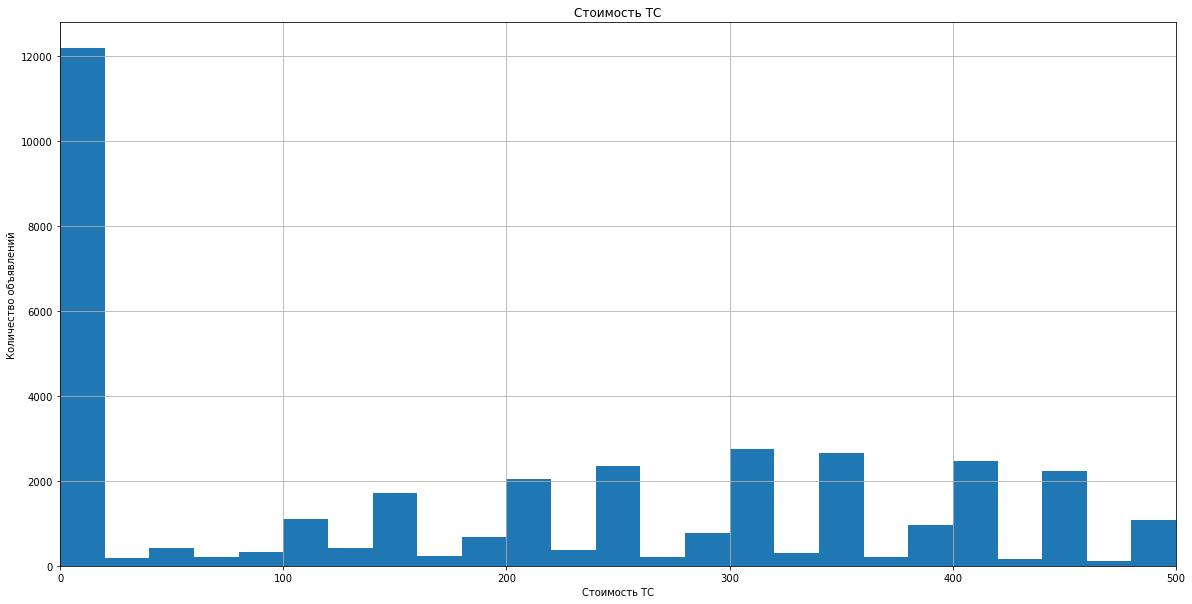

In [169]:
#анализ распределения объявлений по стоимости ТС

plt.xlim(0, 500)

data['Price'].hist(bins=1000, figsize=(20,10))

plt.title('Стоимость ТС')
plt.xlabel('Стоимость ТС')
plt.ylabel('Количество объявлений')
plt.show()

In [170]:
#подсчет доли объявлений с нулевой ценой от общего числа объявлений

len(data.query('Price == 0'))/len(data)*100

3.0398035923412303

In [171]:
#установим нижнюю границу цены за авто

data = data.query('Price > 100')

<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Далее перейдем к анализу года регистрации ТС. Имеются объявления, в которых ТС было зарегистрировано аж в 1000 году, либо в 9999 году. Это явные выбросы и от них необходимо избавиться. Проанализируем долю данных объявлений в выборке.
</div>

In [172]:
print('Доля объявлений ТС с 1000 годом регистрации:{:.2f} %'.
      format(len(data.query('RegistrationYear == 1000'))/len(data)*100))

Доля объявлений ТС с 1000 годом регистрации:0.01 %


In [173]:
print('Доля объявлений ТС с 9999 годом регистрации:{:.4f} %'.
      format(len(data.query('RegistrationYear == 9999'))/len(data)*100))

Доля объявлений ТС с 9999 годом регистрации:0.0038 %


<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Как видно, доля данных объявлений достаточно мала. Проанализируем распределение объявлений и выберем нижний порог по дате регистрации. Верхней границей примем 2016 год, как дату последней выгрузки анкеты из базы.
</div>

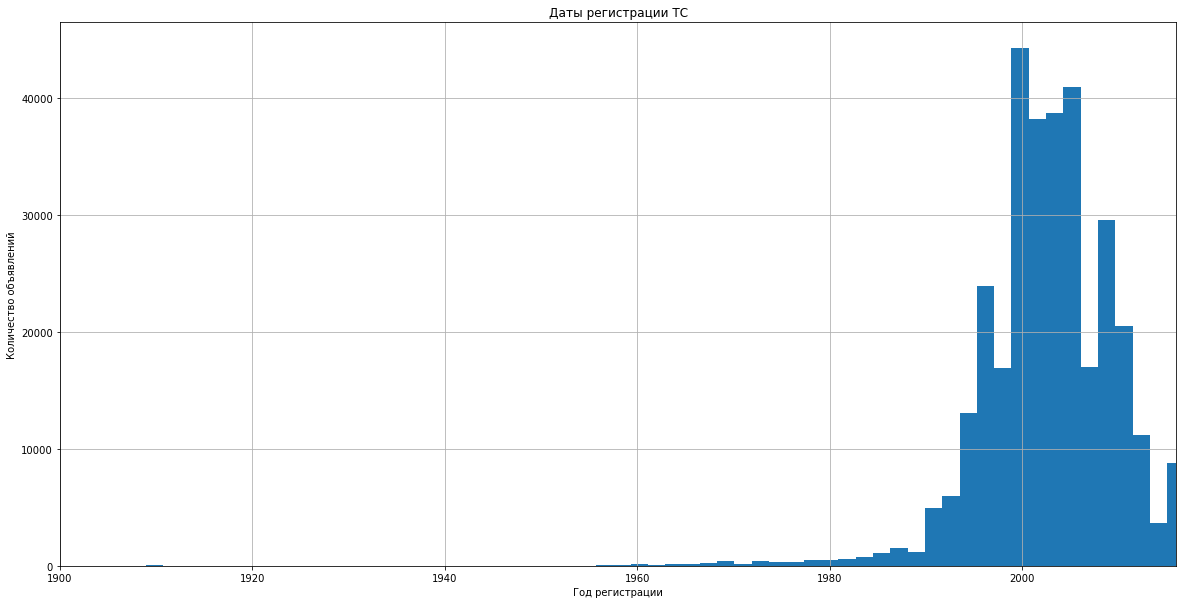

In [174]:
#анализ распределения объявлений по дате регистрации ТС

plt.xlim(1900, 2016)

data['RegistrationYear'].hist(bins=5000, figsize=(20,10))

plt.title('Даты регистрации ТС')
plt.xlabel('Год регистрации')
plt.ylabel('Количество объявлений')
plt.show()

In [175]:
print('Доля объявлений ТС с датой регистрации до 1980 года:{:.2f} %'.
      format(len(data.query('RegistrationYear < 1980'))/len(data)*100))

Доля объявлений ТС с датой регистрации до 1980 года:0.90 %


In [176]:
print('Доля объявлений ТС с датой регистрации после 2016 года:{:.2f} %'.
      format(len(data.query('RegistrationYear > 2017'))/len(data)*100))

Доля объявлений ТС с датой регистрации после 2016 года:1.13 %


<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
По гистограмме можно заметить, что основная доля автомобилей была выпущена после 1980 года. Откинув данные до 1980 года, мы потеряем менее 1% данных. Также около 1% данных уйдут при определении верхней границы даты регистрации ТС.
</div>

In [177]:
#произведем установку границ по дате регистрации в нашем датафрейме

data = data.query('1980<RegistrationYear<2017')

<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Далее перейдем к анализу мощности двигателя автомобилей. В исходной выборке есть значения равные нулю, а также 20 тыс.л.с, что физически невозможно в настоящее время. Оценим с помощью гистограммы распределение объявлений по мощности ТС.
</div>

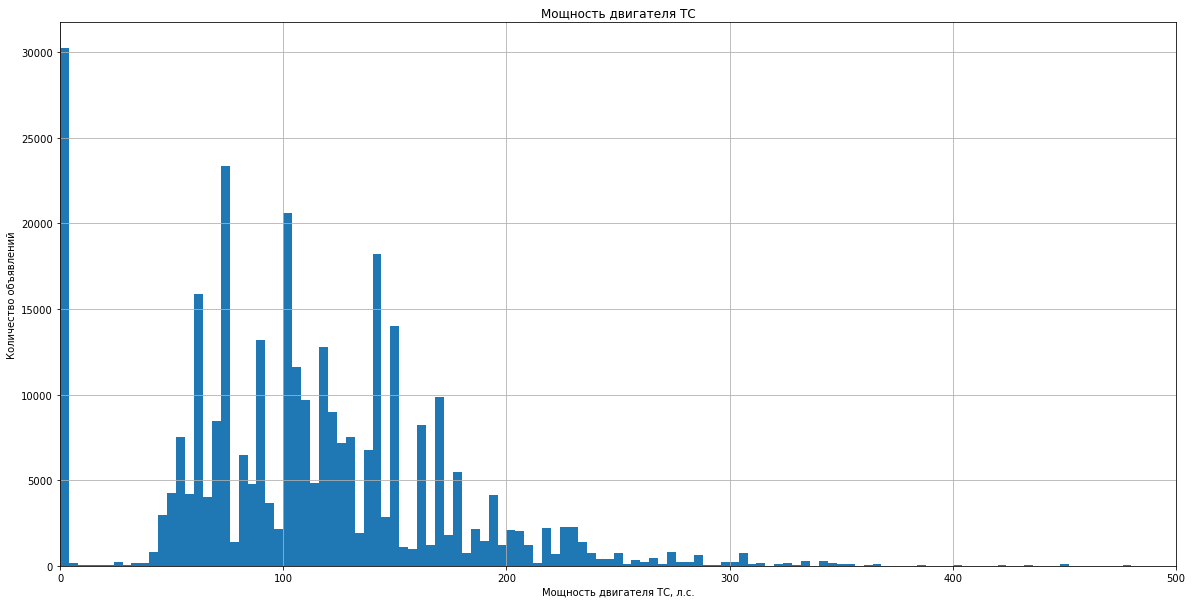

In [178]:
#анализ распределения объявлений по мощности ТС

plt.xlim(0, 500)

data['Power'].hist(bins=5000, figsize=(20,10))

plt.title('Мощность двигателя ТС')
plt.xlabel('Мощность двигателя ТС, л.с.')
plt.ylabel('Количество объявлений')
plt.show()

In [179]:
print('Доля объявлений ТС мощностью двигателя более 350 л.с.:{:.2f} %'.
      format(len(data.query('Power > 350'))/len(data)*100))

Доля объявлений ТС мощностью двигателя более 350 л.с.:0.33 %


In [180]:
print('Доля объявлений ТС мощностью двигателя равной 0 л.с.:{:.2f} %'.
      format(len(data.query('Power == 0'))/len(data)*100))

Доля объявлений ТС мощностью двигателя равной 0 л.с.:9.35 %


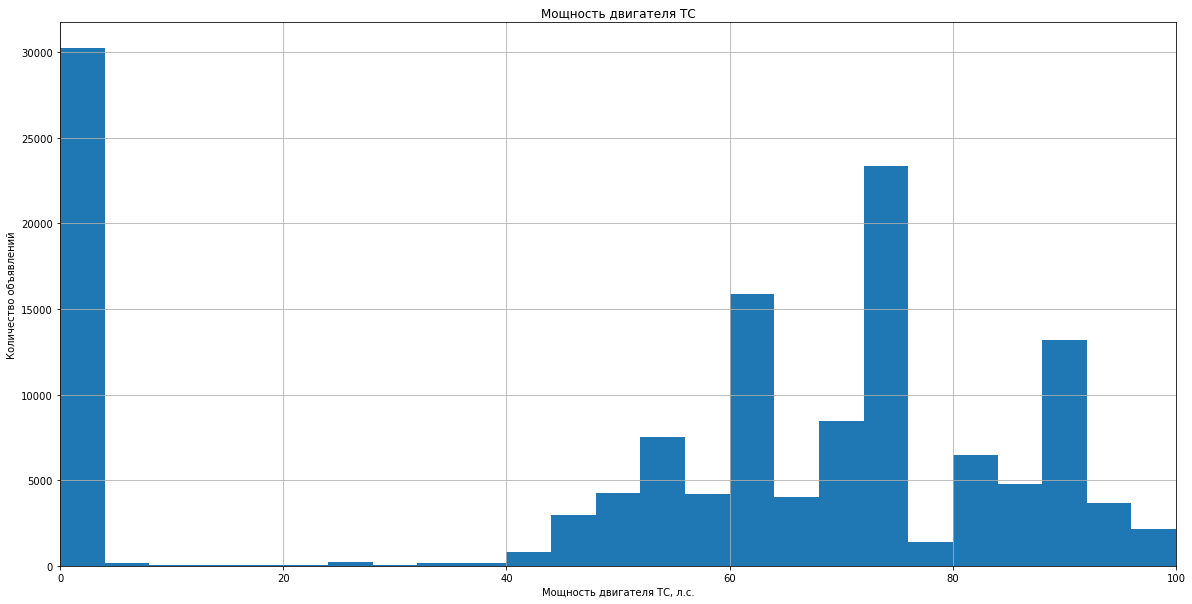

In [181]:
#анализ распределения объявлений по мощности ТС

plt.xlim(0, 100)

data['Power'].hist(bins=5000, figsize=(20,10))

plt.title('Мощность двигателя ТС')
plt.xlabel('Мощность двигателя ТС, л.с.')
plt.ylabel('Количество объявлений')
plt.show()

In [182]:
print('Доля объявлений ТС мощностью двигателя менее 40 л.с.:{:.2f} %'.
      format(len(data.query('Power < 40'))/len(data)*100))

Доля объявлений ТС мощностью двигателя менее 40 л.с.:9.63 %


<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
По первой гистограмме видно, что автомобилей, у которых мощность двигателя свыше 350 л.с., не так много. Поэтому примем верхнюю границу в 350 л.с. Доля объявлений, с такими характеристиками двигателя менее 1%. Также определим нижнюю границу: по второй гистограмме видно, что наибольшее количество ТС, размещенных в объявлениях, имеют мощность двигателя более 40 л.с. Отбросив объявления, в которых мощность двигателя менее 40 л.с., мы потеряем 10.73% исходных данных, из которых 10.44% - объявления с нулевой мощностью двигателя. Восстановить данный параметр не представляется возможным ввиду большого количества дополнительных характеристик.
</div>

In [183]:
#произведем установку границ по мощности двигателей ТС в нашем датафрейме

data = data.query('40<Power<350')

In [184]:
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
354361,5250,NaN,2016,auto,150,159,150000,NaN,alfa_romeo,no
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


### Обработка пропущенных значений

<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Далее перейдем к обработке пропущенных значений в датафрейме.
</div>

In [185]:
#оценим долю пропущенных значений по столбцам датафрейма

data.isna().mean()

Price              0.000
VehicleType        0.036
RegistrationYear   0.000
Gearbox            0.017
Power              0.000
Model              0.035
Kilometer          0.000
FuelType           0.051
Brand              0.000
NotRepaired        0.143
dtype: float64

In [186]:
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
354361,5250,NaN,2016,auto,150,159,150000,NaN,alfa_romeo,no
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Начнем с обработки пропущенных значений по столбцу 'VehicleType'. Заменим пропущенные значения популярным типом кузова для конкретной марки.
</div>

In [187]:
data['VehicleType'] = data.groupby(['Brand'])['VehicleType'].\
                        transform(lambda x: x.fillna(x.value_counts(dropna=False).index[0]))

<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Далее перейдем к обработке пропущенных значений по столбцу с указанием коробки передач. Пропущенных значений по данному столбцу порядка 2%. Пользователь не указал тип коробки передач. Примем, что у таких машин коробка передач механическая.
</div>

In [188]:
#произведем заполнение пропущенных значений

data['Gearbox'] = data['Gearbox'].fillna(value='manual')

<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Далее перейдем к обработке пропущенных значений по столбцу c указанием модели машины. Пропущенных значений по данному столбцу порядка 4%. Заполним пропущенные значения самыми популярными моделями по бренду и типу кузова.
</div>

In [189]:
data['Model'] = data.groupby(['Brand', 'VehicleType'])['Model'].\
                        transform(lambda x: x.fillna(x.value_counts(dropna=False).index[0]))

In [190]:
#проверка количества оставшихся пропущенных значений

data['Model'].isna().sum()

1247

In [191]:
#удалим данные строки

data.dropna(subset=['Model'], inplace=True)

In [192]:
data.isna().mean()

Price              0.000
VehicleType        0.000
RegistrationYear   0.000
Gearbox            0.000
Power              0.000
Model              0.000
Kilometer          0.000
FuelType           0.051
Brand              0.000
NotRepaired        0.143
dtype: float64

<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Далее перейдем к обработке пропущенных значений по столбцу c указанием типа топлива. Пропущенных значений по данному столбцу порядка 5,5%. Заполним пропущенные значения самыми популярными типами топлива по бренду и модели автомобиля.
</div>

In [193]:
data['FuelType'] = data.groupby(['Brand', 'Model'])['FuelType'].\
                        transform(lambda x: x.fillna(x.value_counts(dropna=False).index[0]))

<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Далее перейдем к обработке пропущенных значений по столбцу c указанием наличия ремонта по машине. Пропущенных значений по данному столбцу порядка 14,9%. Пропущенные значения заменим на "No", предполагая, что автомобилисты пропустили данную графу при заполнении анкеты.
</div>

In [194]:
#произведем заполнение пропущенных значений

data['NotRepaired'] = data['NotRepaired'].fillna(value='no')

In [195]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289140 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             289140 non-null  int64 
 1   VehicleType       289140 non-null  object
 2   RegistrationYear  289140 non-null  int64 
 3   Gearbox           289140 non-null  object
 4   Power             289140 non-null  int64 
 5   Model             289140 non-null  object
 6   Kilometer         289140 non-null  int64 
 7   FuelType          289140 non-null  object
 8   Brand             289140 non-null  object
 9   NotRepaired       289140 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.3+ MB


<div class="alert alert-info">
<b>ВЫВОД:</b>
<br>
В данном разделе произвели первичный анализ информации, а также заменили пропущенные значения.
</div>

## Обучение моделей

<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Перейдем к подготовке признаков. Техникой ОНЕ преобразуем категориальные признаки в численные.
</div>

In [196]:
data = pd.get_dummies(data, drop_first=True)

data

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
1,18300,2011,190,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1500,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,3600,2008,69,90000,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
5,650,1995,102,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,2016,150,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
354362,3200,2004,225,150000,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
354366,1199,2000,101,125000,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
354367,9200,1996,102,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Далее нам необходимо разделить выборку на обучающую и тестовую.
Т.к. у нас нет спрятанной тестовой выборки поделим исходные данные в отношении 75:25%.
</div>

In [197]:
#для начала отделим обучающую выборку от валидационной и тестовой

target = data['Price']
features = data.drop('Price', axis=1)

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, 
                                                                              random_state=12345)

#далее узнаем размеры выборок

print('Размер обучающей выборки равен: ', features_train.shape)
print('Размер тестовой выборки равен: ', features_test.shape)

Размер обучающей выборки равен:  (216855, 303)
Размер тестовой выборки равен:  (72285, 303)


<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Теперь проведем масштабирование количественных признаков с помощью их стандартизации.
</div>

In [200]:
numeric = ['RegistrationYear', 'Power', 'Kilometer']

scaler = StandardScaler()
scaler.fit(features_train[numeric]) 

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric]= scaler.transform(features_valid[numeric]) 
features_test[numeric]= scaler.transform(features_test[numeric]) 

features_train

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
97145,-1.911,-0.848,0.585,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
82764,-1.052,0.583,0.585,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
47628,-1.224,-0.593,0.585,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
201761,-0.365,-0.201,0.585,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
286588,0.150,-1.024,-1.622,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194708,-3.456,-0.887,0.585,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
58785,-0.881,0.368,0.585,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105788,0.493,-1.083,0.585,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
94638,0.837,-1.220,-1.898,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Перейдем к обучению моделей. Начнем с модели "Дерево решений".
</div>

In [201]:
%%time
#зададим гиперпараметры дерева решений

max_depth = [3, 5, 10]

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

max_features = [1, 9, 15, 20]

dt_grid = {'max_depth': max_depth,
           'min_samples_split': min_samples_split,
           'min_samples_leaf': min_samples_leaf,
           'max_features': max_features
           }

model_dt = GridSearchCV(DecisionTreeRegressor(random_state=12345), dt_grid, scoring = 'neg_root_mean_squared_error')
# обучаем модель
model_dt.fit(features_train, target_train)

Wall time: 10min 32s


GridSearchCV(estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': [3, 5, 10],
                         'max_features': [1, 9, 15, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_root_mean_squared_error')

In [202]:
#определяем лучшие гиперпараметры для дерева решений

print('Наивысшая оценка: %s' % -model_dt.best_score_)
print('Лучшие гиперпараметры: %s' % model_dt.best_params_)

Наивысшая оценка: 2939.8881780670013
Лучшие гиперпараметры: {'max_depth': 10, 'max_features': 20, 'min_samples_leaf': 2, 'min_samples_split': 10}


<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Далее рассмотрим модель случайного леса.
</div>

In [203]:
%%time
#зададим гиперпараметры случайного леса

n_estimators = [3, 5, 7, 10]

max_depth = [3, 5, 10]

max_features = ['auto']

min_samples_split = [5, 10]

min_samples_leaf = [2, 4]

rf_grid = {'n_estimators': n_estimators,
           'max_features': max_features,
           'max_depth': max_depth,
           'min_samples_split': min_samples_split,
           'min_samples_leaf': min_samples_leaf
           }

model_rf = GridSearchCV(RandomForestRegressor(random_state=12345), rf_grid, scoring = 'neg_root_mean_squared_error')
# обучаем модель
model_rf.fit(features_train,target_train)

Wall time: 1h 4min 52s


GridSearchCV(estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [3, 5, 10], 'max_features': ['auto'],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': [5, 10],
                         'n_estimators': [3, 5, 7, 10]},
             scoring='neg_root_mean_squared_error')

In [204]:
#определяем лучшие гиперпараметры для случайного леса

print('Наивысшая оценка: %s' % -model_rf.best_score_)
print('Лучшие гиперпараметры: %s' % model_rf.best_params_)

Наивысшая оценка: 1811.7147262914855
Лучшие гиперпараметры: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}


<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Далее обучим модель бустинга CatBoostRegressor.
</div>

In [205]:
%%time

n_estimators = [10, 30, 50, 70, 100]
depth = [1, 3, 5, 7, 10]

cb_grid = {'n_estimators': n_estimators,
           'depth': depth}

model_cb =  GridSearchCV(CatBoostRegressor(random_seed=12345), cb_grid, scoring = 'neg_root_mean_squared_error')
# обучаем модель
model_cb.fit(features_train,target_train)

Learning rate set to 0.5
0:	learn: 3847.9183187	total: 7.56ms	remaining: 68ms
1:	learn: 3504.1175974	total: 13ms	remaining: 52ms
2:	learn: 3252.1621416	total: 18.4ms	remaining: 42.9ms
3:	learn: 3109.9648127	total: 23.4ms	remaining: 35ms
4:	learn: 2999.2290907	total: 27.7ms	remaining: 27.7ms
5:	learn: 2883.8655973	total: 31.7ms	remaining: 21.1ms
6:	learn: 2809.5473156	total: 35.8ms	remaining: 15.3ms
7:	learn: 2728.7012616	total: 39.7ms	remaining: 9.92ms
8:	learn: 2670.0909927	total: 43.7ms	remaining: 4.86ms
9:	learn: 2626.8370616	total: 47.6ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3849.2421317	total: 7.29ms	remaining: 65.6ms
1:	learn: 3506.1658209	total: 11.9ms	remaining: 47.4ms
2:	learn: 3254.5949956	total: 15.9ms	remaining: 37.2ms
3:	learn: 3112.0778312	total: 20ms	remaining: 30ms
4:	learn: 3003.2234785	total: 24.3ms	remaining: 24.3ms
5:	learn: 2887.2602173	total: 30.1ms	remaining: 20.1ms
6:	learn: 2814.0924670	total: 35.9ms	remaining: 15.4ms
7:	learn: 2737.2860068	total: 

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x000001F395458BE0>,
             param_grid={'depth': [1, 3, 5, 7, 10],
                         'n_estimators': [10, 30, 50, 70, 100]},
             scoring='neg_root_mean_squared_error')

In [206]:
#определяем лучшие гиперпараметры для CatBoostRegressor

print('Наивысшая оценка: %s' % -model_cb.best_score_)
print('Лучшие гиперпараметры: %s' % model_cb.best_params_)

Наивысшая оценка: 1515.1332396433238
Лучшие гиперпараметры: {'depth': 10, 'n_estimators': 100}


<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Далее обучим модель бустинга LightGBMRegressor.
</div>

In [207]:
%%time

n_estimators = [10, 30, 50, 70, 100]
depth = [1, 3, 5, 7, 10]

lgbm_grid = {'n_estimators': n_estimators,
           'max_depth': depth
           }

model_lgbm =  GridSearchCV(LGBMRegressor(random_seed=12345), lgbm_grid, scoring = 'neg_root_mean_squared_error')
# обучаем модель
model_lgbm.fit(features_train,target_train)

Wall time: 4min 1s


GridSearchCV(estimator=LGBMRegressor(random_seed=12345),
             param_grid={'max_depth': [1, 3, 5, 7, 10],
                         'n_estimators': [10, 30, 50, 70, 100]},
             scoring='neg_root_mean_squared_error')

In [208]:
#определяем лучшие гиперпараметры для LightGBMRegressor

print('Наивысшая оценка: %s' % -model_lgbm.best_score_)
print('Лучшие гиперпараметры: %s' % model_lgbm.best_params_)

Наивысшая оценка: 1614.4912292237277
Лучшие гиперпараметры: {'max_depth': 10, 'n_estimators': 100}


In [210]:
speed_of_learning = pd.DataFrame({'Модель регрессии': 
                                  ['Дерево решений', 'Случайный лес', 'CatBoostRegressor', 'LGBMRegressor'],
                                 'Время обучения модели': 
                                  ['10min 32s', '1h 4min 52s', '3min 22s', '4min 1s'],
                                 'Метрика RMSE на обучающей выборке': 
                                  ['2939.88', '1811.71', '1515.13', '1614.49']                                 
                                 })
speed_of_learning

,Модель регрессии,Время обучения модели,Метрика RMSE на обучающей выборке
0,Дерево решений,10min 32s,2939.88
1,Случайный лес,1h 4min 52s,1811.71
2,CatBoostRegressor,3min 22s,1515.13
3,LGBMRegressor,4min 1s,1614.49


<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
В результате обучения 4 различных моделей было выявлено следующее: наилучший результат по скорости обучения и по метрике RMSE показал бустинг CatBoostRegressor. Также довольно хороший результат показал бустинг LGBMRegressor. Модель случайного леса показала хороший результат по метрике RMSE, но гораздо дольше обучалась.
</div>

## Анализ моделей

In [211]:
%%time 

#получение предсказания модели CatBoostRegressor на тестовой выборке

predicted_cb_test = model_cb.predict(features_test)

print('Метрика качества RMSE на модели CatBoostRegressor на тестовой выборке:{:.2f}'.
      format(mean_squared_error(predicted_cb_test, target_test)**0.5))

Метрика качества RMSE на модели CatBoostRegressor на тестовой выборке:1518.15
Wall time: 40.8 ms


<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Построим константную модель для сравнения полученных результатов.
</div>

In [212]:
%%time

#зададим гиперпараметры для DummyRegressor

strategy = ['mean', 'median', 'quantile', 'constant']

dr_grid = {'strategy': strategy}

model_dr = GridSearchCV(DummyRegressor(), dr_grid, scoring = 'neg_root_mean_squared_error')
# обучаем модель
model_dr.fit(features_train,target_train)

Wall time: 9.34 s


GridSearchCV(estimator=DummyRegressor(),
             param_grid={'strategy': ['mean', 'median', 'quantile',
                                      'constant']},
             scoring='neg_root_mean_squared_error')

In [213]:
#определяем лучшие гиперпараметры для DummyRegressor

print('Наивысшая оценка: %s' % -model_dr.best_score_)
print('Лучшие гиперпараметры: %s' % model_dr.best_params_)

Наивысшая оценка: 4567.875576388529
Лучшие гиперпараметры: {'strategy': 'mean'}


In [214]:
%%time

#получение предсказания модели DummyRegressor на тестовой выборке

predicted_dr_test = model_dr.predict(features_test)

print('Метрика качества RMSE на модели DummyRegressor на тестовой выборке:{:.2f}'.
      format(mean_squared_error(predicted_dr_test, target_test)**0.5))

Метрика качества RMSE на модели DummyRegressor на тестовой выборке:4583.01
Wall time: 1.99 ms


In [215]:
compare_model = pd.DataFrame({'Модель регрессии': 
                                  ['CatBoostRegressor', 'DummyRegressor'],
                                 'Время предсказания модели': 
                                  ['40.8 ms', '1.99 ms'],
                                 'Метрика RMSE на тестовой выборке': 
                                  ['1518.15', '4583.01']                                 
                                 })
compare_model

,Модель регрессии,Время предсказания модели,Метрика RMSE на тестовой выборке
0,CatBoostRegressor,40.8 ms,1518.15
1,DummyRegressor,1.99 ms,4583.01


<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Модель DummyRegressor показала результаты значительно хуже, т.к. метрика RMSE получилась выше. Значит построенная нами модель CatBoostRegressor вполне адекватна.
</div>